In [ ]:
pip install rasterio

In [ ]:
import rasterio
import numpy as np
from sklearn.decomposition import NMF,PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from scipy.optimize import nnls
from sklearn.decomposition import NMF

# Load the TIFF image
with rasterio.open('large.tif') as src:
    image = src.read()
# endmember_spectra = np.loadtxt('spectra.txt', skiprows=9)


In [133]:
from sklearn.linear_model import Lasso

# Preprocess the data
image = image.astype(np.float32)  # Convert to float32
image = image / np.max(image)  # Normalize to [0, 1]

# Reshape the data to (pixels, bands)
# image.shape[0]: BANDS
#  -1 flattens the pixels to h x w total pixels
pixels = image.reshape(image.shape[0], -1).T  # Shape: (number_of_pixels, bands) = (h x w, 135) = (1008,135)
number_of_pixels=pixels.shape[0]


# Read endmember spectra from ASCII file
endmember_spectra = np.loadtxt('spectra.txt', skiprows=9)  # Shape: (135, 8)

# Drop the first endmember
endmember_spectra = endmember_spectra[:, 2:]  # Shape is now (135, 7) = (bands, endmember_count)
endmember_count = endmember_spectra.shape[1]

# abudances shape = (number_of_pixels, endmember_count)
abundances = np.zeros((number_of_pixels, endmember_count))  # Initialize abundance matrix



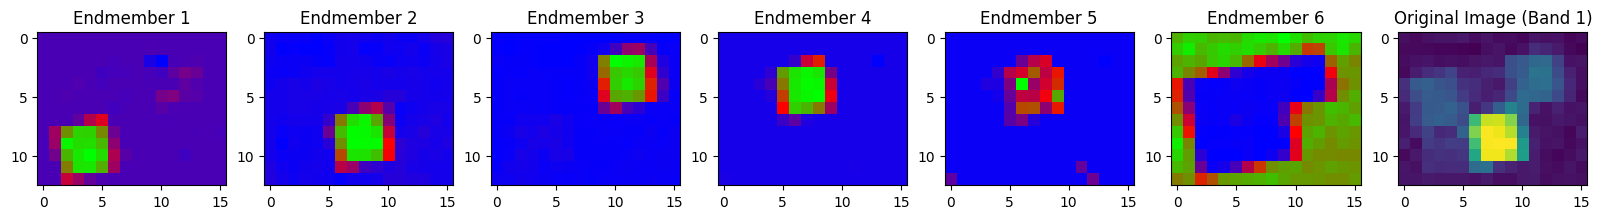

In [134]:
model='lasso'
if model=='lasso':
  # Perform Lasso Regression for each pixel
  lasso = Lasso(alpha=0.2)  # Alpha is the regularization strength
  for i in range(number_of_pixels):
      lasso.fit(endmember_spectra, pixels[i])  # Fit remaining endmembers to the pixel
      abundances[i, :] = lasso.coef_  # Get the coefficients (abundances) for this pixel

if model=='elastic_net':
  elastic_net = ElasticNet(alpha=0.2, l1_ratio=0.5)  # l1_ratio controls the mix of Lasso and Ridge
  for i in range(number_of_pixels):
      elastic_net.fit(endmember_spectra, pixels[i])
      abundances[i, :] = elastic_net.coef_

if model=='nmf':
  nmf = NMF(n_components=endmember_count, init='random', random_state=0)
  abundances = nmf.fit_transform(pixels)

# Reshape the abundances to (rows, columns, endmembers)
abundances = abundances.reshape(image.shape[1], image.shape[2], endmember_count)

# Normalize abundances to [0, 1]
abundances = abundances / np.max(abundances, axis=(0, 1, 2), keepdims=True)

# Visualize the results
fig, axs = plt.subplots(1, endmember_spectra.shape[1] + 1, figsize=(20, 16))
for i in range(endmember_spectra.shape[1]):
    axs[i].imshow(abundances[..., i], cmap='brg')
    axs[i].set_title(f'Endmember {i + 1}')
axs[-1].imshow(image[0])
axs[-1].set_title('Original Image (Band 1)')
plt.show()

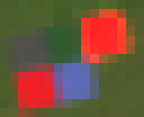